In [1]:
import numpy as np 
import pandas as pd 
import string
import re
import seaborn as sns
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import pickle
import nltk
from collections import Counter

## torch ##
import torchvision
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary


nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/hyunji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 이미지 캡셔닝 과정 
(1) 이미지를 입력으로 받습니다.  
(2) CNN을 지나면서 해당 이미지에 대한 요약된 벡터 값을 받습니다. 이때, 기존 CNN의 마지막에 있는 softmax는 제거된 상태입니다.  
(3) 받은 값을 기존 Vanilla RNN식에 추가하여 계산하게 됩니다. 처음 x0값은 START라는 토큰 값이 주어지게 되고, 모든 단어를 RNN을 통해 출력합니다.  
(4) 마지막에 더 이상 출력할 것이 없으면 END 토큰으로 종료되게 됩니다. 이미지 캡셔닝에서는 마지막에 END 토큰을 출력하는 것도 학습을 시켜줘야 합니다.  

Flicker8k는 각 이미지 별로 설명 정보가 5개씩 있음
=> 총 40000개의 텍스트가 존재함

1. 이미지 크기 256x256으로 조정
2. train을 6000개 test, validation를 1000개씩 생성
    => 총 8091개의 이미지 마다 5개의 catpion이 붙어 있으므로 총 40455개의 문장 존재
3. Catpion을 이용하여 Vocabulary만들기

In [2]:
df = pd.read_csv("../Deeplearning_Project/rawdata/captions.txt")
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [3]:
paths=[]
files=[]
for dirname, _, filenames in os.walk('../Deeplearning_Project/rawdata/Images'):
    for filename in filenames:
        paths+=[os.path.join(dirname, filename)]
        files+=[filename]

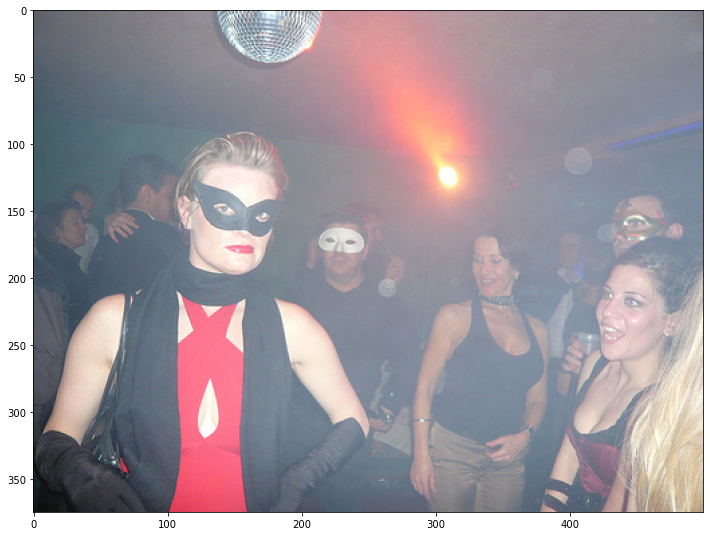

- A group of people are partying at a masquerade party .
- A lady in red and black grins at the camera at a costume party .
- A woman in a domino mask and severe hair is at a party .
- A woman in a red dress and black mask is on a crowded dance floor
- A woman wears a red dress and a black mask while people dance behind her .




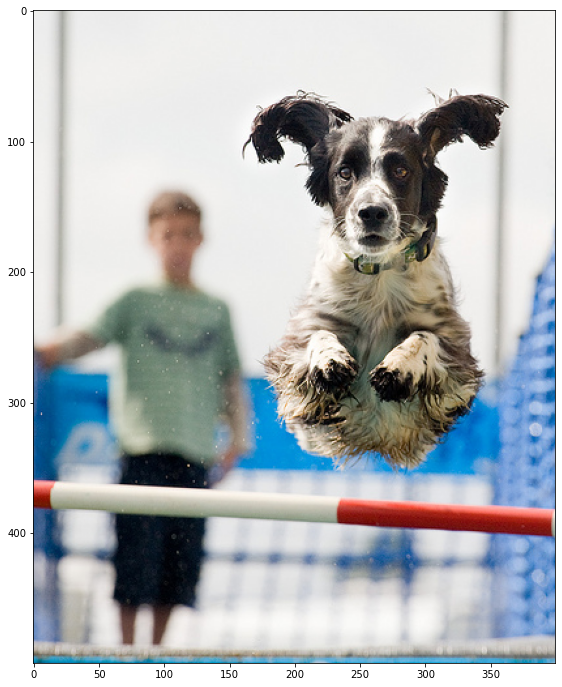

- A black and white dog jumping over a red and white bar .
- A black and white dog jumps over a red and white pole while a boy in a green shirt watches .
- A dog is jumping over a red and white bar .
- A dog jumping over a pole with a boy in the background
- Dog jumps over red and white pole while boy looks on




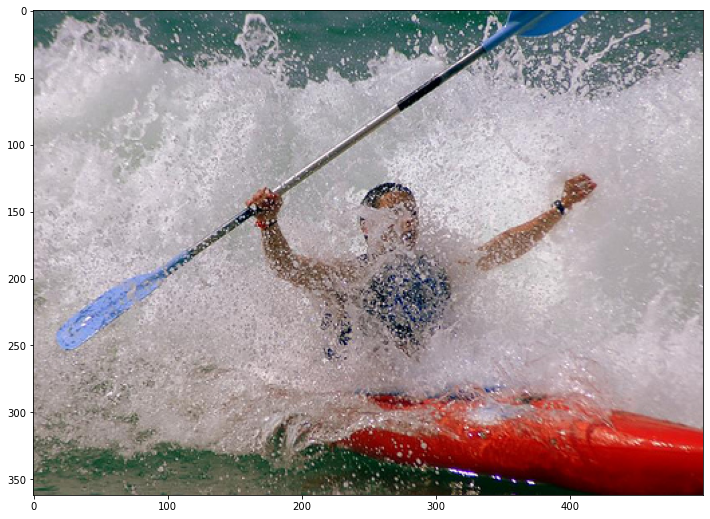

- A man in a kayak is holding his paddle up high .
- A man is kayaking through rough water .
- Kayak rider raises arms as he 's splashed with water .
- Spray obscures the face and torso of the paddle wielding man in the red kayak .
- The kayaker holding an oar , is raising both arms in the air , while waves splash around him .




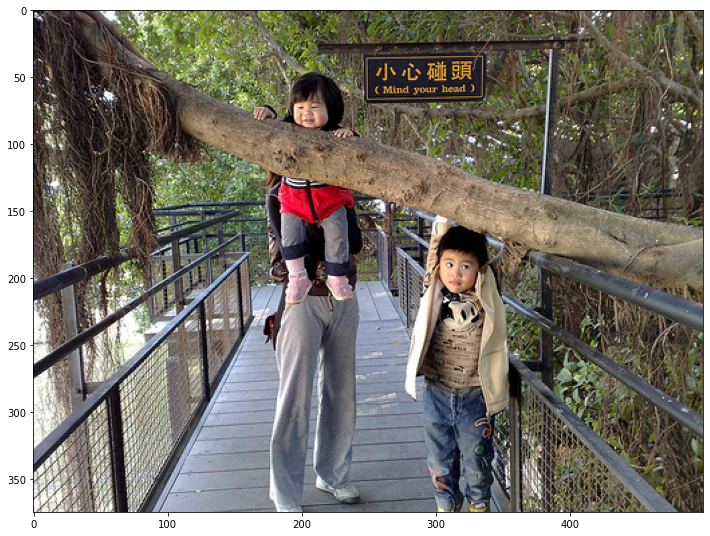

- a woman holding a baby hanging from a branch and a small child hanging on that same branch .
- Two asian kids are playing with a very large tree branch .
- Two children and an adult standing next to a tree limb .
- Two children hang from a low tree branch
- Two children hanging on a large branch .




In [8]:
for i in [0,3,5,7]:
    fig=plt.figure(figsize=(12,12))
    img=cv2.imread(paths[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    catpions=df[df['image']==files[i]].reset_index(drop=True)['caption'].tolist()
    for caption in catpions:
        print('-',caption)
    print()
    print()

# Data Preprocessing
    - resize_image
    - train validation test split

In [4]:
import os
from PIL import Image

image_dir = "../Deeplearning_Project/rawdata/Images" # 원본 이미지 파일 경로
train_image_dir = "./resized_train/images" # 크기가 조정된 이미지가 담길 경로 (학습)
val_image_dir = "./resized_val/images" # 크기가 조정된 이미지가 담길 경로 (평가)
test_image_dir = "./resized_test/images" # 크기가 조정된 이미지가 담길 경로 (테스트)
size = [256, 256] # 조정될 이미지 크기


def resize_image(image, size):
    # 이미지를 특정 크기로 조정
    return image.resize(size, Image.ANTIALIAS)

# image_dir 내부에 있는 모든 이미지의 크기를 바꾸어 결과 폴더로 옮기기
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
if not os.path.exists(val_image_dir):
    os.makedirs(val_image_dir)
if not os.path.exists(test_image_dir):
    os.makedirs(test_image_dir)

images = sorted(os.listdir(image_dir)) # 이미지와 캡션 모두 파일 이름별로 정렬해서 매칭
num_images = len(images)
num_train_images = 6000 # 6000개는 학습용 데이터로 이용
num_val_images = 1000 # 1000개는 평가용 데이터로 이용

for i, image in enumerate(images):
    #학습용 파일로 resized된 사진 이동
    if (i + 1) <= num_train_images:
        output_dir = train_image_dir
    #평가용 파일로 resized된 사진 이동
    elif (i + 1) <= num_train_images + num_val_images:
        output_dir = val_image_dir
    #test용 파일로 resized된 사진 이동
    else:
        output_dir = test_image_dir
    with open(os.path.join(image_dir, image), 'rb+') as f:
        with Image.open(f) as img:
            img = resize_image(img, size)
            img.save(os.path.join(output_dir, image), img.format)
    if (i + 1) % 500 == 0:
        print(f"[{i + 1}/{num_images}] Resized the images and saved into '{output_dir}'")

<ipython-input-4-379984916f13>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  return image.resize(size, Image.ANTIALIAS)


[500/8091] Resized the images and saved into './resized_train/images'
[1000/8091] Resized the images and saved into './resized_train/images'
[1500/8091] Resized the images and saved into './resized_train/images'
[2000/8091] Resized the images and saved into './resized_train/images'
[2500/8091] Resized the images and saved into './resized_train/images'
[3000/8091] Resized the images and saved into './resized_train/images'
[3500/8091] Resized the images and saved into './resized_train/images'
[4000/8091] Resized the images and saved into './resized_train/images'
[4500/8091] Resized the images and saved into './resized_train/images'
[5000/8091] Resized the images and saved into './resized_train/images'
[5500/8091] Resized the images and saved into './resized_train/images'
[6000/8091] Resized the images and saved into './resized_train/images'
[6500/8091] Resized the images and saved into './resized_val/images'
[7000/8091] Resized the images and saved into './resized_val/images'
[7500/8091]

### 문장 전처리 (소문자화 , 특수문자 제거)

In [6]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
def clean_text(row):
    row = str(row).strip()
    row = row.lower()
    return regex.sub("", row)

df.columns = [col.strip() for col in df.columns]
df["caption"] = df["caption"].apply(clean_text)

In [7]:
df["length"] = df["caption"].apply(lambda row: len(row.strip().split()))
df.head()

,image,caption,length
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...,17
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building,7
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse,8
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...,9
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...,12


### 단어 개수의 분포 파악

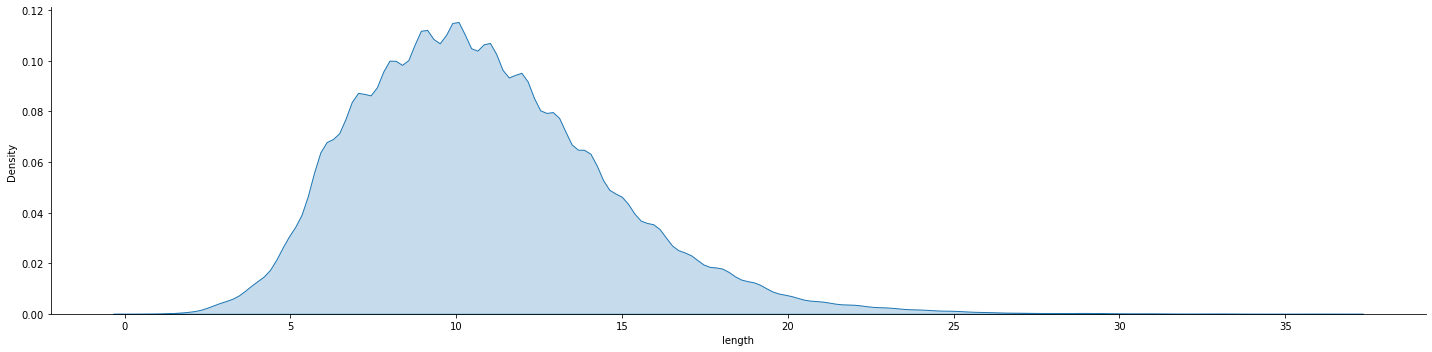

In [8]:
sns.displot(data=df, x='length', palette='mako', kind='kde', fill=True, aspect=4)

### 단어 빈도수 파악

In [9]:
captions = df["caption"].tolist()

In [10]:
word_freq = {}
for comment in captions:
    comment = comment.strip()
    for word in comment.split():
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

dict(sorted(word_freq.items() , key=lambda item: item[1], reverse=True)[:30])

{'a': 62986,
 'in': 18974,
 'the': 18418,
 'on': 10743,
 'is': 9345,
 'and': 8851,
 'dog': 8136,
 'with': 7765,
 'man': 7265,
 'of': 6713,
 'two': 5638,
 'white': 3940,
 'black': 3832,
 'boy': 3581,
 'are': 3504,
 'woman': 3402,
 'girl': 3328,
 'to': 3173,
 'wearing': 3062,
 'at': 2914,
 'people': 2883,
 'water': 2783,
 'red': 2672,
 'young': 2630,
 'brown': 2563,
 'an': 2432,
 'his': 2357,
 'blue': 2268,
 'dogs': 2125,
 'running': 2073}

## Caption Preprocessing

caption으로 부터 **'vocab'** 딕셔너리를 만들어줍니다.  
PAD, UNK, START, END도 vocab에 넣어줍니다.
word_threshold보다 단어 등장의 빈도수가 많으면 vocab에 넣어줍니다.
   
> Return 예시   
word2idx = {'a': 62986,'in': 18974,'the': 18418,'on': 10743,...}   
idx2word = {62986 : "a", 18974 : 'in', 18418 : "the", ....}


In [5]:
caption_path = "../Deeplearning_Project/rawdata/captions.txt" # 원본 캡션(caption) 파일
vocab_path = "../Deeplearning_Project/vocab.pkl" # 단어 사전 결과 파일
word_threshold = 4 # 최소 단어 등장 횟수
train_caption_path = "./resized_train/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (학습)
val_caption_path = "./resized_val/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (평가)
test_caption_path = "./resized_test/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (테스트)

class Vocabulary(object):
    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        #word마다 index를 붙여주는 작업 시행
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __call__(self, word):
        #존재하지 않는 단어는 <unk> 처리
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

counter = Counter()

#이미지를 한장씩 확인
with open(caption_path, "r") as f:
    lines = sorted(f.readlines()[1:])
    for i in range(len(lines)):
        line = lines[i]
        
        #line의 결과는 아래와 같다. 따라서 쉼표를 찾아 제거해준다.
        #1000268201_693b08cb0e.jpg, A child in a pink dress is climbing up a set of stairs in an entry way .
        
        if (i + 1) <= num_train_images * 5: 
            #학습용 파일로 전처리된 caption이동
            # *5한 이유는 이미지당 캡션이 5개씩 존재하기 때문이다.
            output_caption = train_caption_path
        elif (i + 1) <= (num_train_images + num_val_images) * 5:
            #평가용 파일로 전처리된 caption이동
            output_caption = val_caption_path
        else:
            #test용 파일로 전처리된 caption이동
            output_caption = test_caption_path
            
        index = line.find(",") # 캡션(caption) 문자열의 시작점 찾기
        
        caption = line[index + 1:] # 문자열 시작점(,) 이후는 캡션임. 캡션(caption) 문자열을 기록한다.

        tokens = nltk.tokenize.word_tokenize(caption.lower()) # 소문자로 이루어진 문자열 토큰화
        
        counter.update(tokens) # 각 토큰의 개수 세기

        with open(output_caption, "a") as output_caption_f:
            output_caption_f.write(line)

# 단어의 빈도수가 특정 임계치(threshold) 여기선 4번 이상인 경우에만 사용
# Counter 는 Counter({'a': 3, 'in': 2, 'child': 1, 'pink': 1...})이런식으로 나옴
words = [word for word, cnt in counter.items() if cnt >= word_threshold]

# Vocabulary 객체 생성
# key : string text, value : token index

vocab = Vocabulary() 

vocab.add_word('<pad>') # 문장의 길이를 맞춰주기 위함
vocab.add_word('<start>') #문장의 시작
vocab.add_word('<end>') # 문장의 끝
vocab.add_word('<unk>') # unknown 토큰


# Vocabulary 객체에 모든 단어를 담기
for word in words:
    vocab.add_word(word)


#등장한 단어는 스킵하고 등장하지 않은 단어일때 index+1되어서 딕셔너리에 담김

# Vocabulary 파일 저장
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

In [24]:
#vacab확인
vocab.word2idx

{'<pad>': 0,
 '<start>': 1,
 '<end>': 2,
 '<unk>': 3,
 'a': 4,
 'child': 5,
 'in': 6,
 'pink': 7,
 'dress': 8,
 'is': 9,
 'climbing': 10,
 'up': 11,
 'set': 12,
 'of': 13,
 'stairs': 14,
 'an': 15,
 'way': 16,
 '.': 17,
 'girl': 18,
 'going': 19,
 'into': 20,
 'wooden': 21,
 'building': 22,
 'little': 23,
 'playhouse': 24,
 'the': 25,
 'to': 26,
 'her': 27,
 'cabin': 28,
 'black': 29,
 'dog': 30,
 'and': 31,
 'spotted': 32,
 'are': 33,
 'fighting': 34,
 'tri-colored': 35,
 'playing': 36,
 'with': 37,
 'each': 38,
 'other': 39,
 'on': 40,
 'road': 41,
 'white': 42,
 'brown': 43,
 'spots': 44,
 'staring': 45,
 'at': 46,
 'street': 47,
 'two': 48,
 'dogs': 49,
 'different': 50,
 'breeds': 51,
 'looking': 52,
 'pavement': 53,
 'moving': 54,
 'toward': 55,
 'covered': 56,
 'paint': 57,
 'sits': 58,
 'front': 59,
 'painted': 60,
 'rainbow': 61,
 'hands': 62,
 'bowl': 63,
 'sitting': 64,
 'large': 65,
 'small': 66,
 'grass': 67,
 'plays': 68,
 'canvas': 69,
 'it': 70,
 'there': 71,
 'pigtails

In [6]:
# 학습(train) 데이터셋의 캡션 수
!wc -l ./resized_train/captions.txt
# 평가(val) 데이터셋의 캡션 수
!wc -l ./resized_val/captions.txt
# 테스트(test) 데이터셋의 캡션 수
!wc -l ./resized_test/captions_new.txt

  628388 ./resized_train/captions.txt
  100000 ./resized_val/captions.txt
    5455 ./resized_test/captions_new.txt


## Caption to Token

In [7]:
# Flickr8k 데이터셋 클래스 정의 
# 이미지와 문장들을 pair로 묶어서

class Flickr8kDataset(data.Dataset):
    def __init__(self, root, captions, vocab, transform=None):
        self.root = root # resized된 이미지가 존재하는 경로
        with open(captions, "r") as f:
            lines = f.readlines()
            self.captions = [] # 캡션(caption) 정보를 담을 리스트
            for line in lines: # 첫 번째 줄부터 바로 캡션 정보 존재
                index = line.find(",") # 캡션(caption) 문자열의 시작점 찾기
                path = line[:index] # path : 이미지 파일 이름
                caption = line[index + 1:] #  caption : 캡션(caption)
                self.captions.append((path, caption))
                
        self.vocab = vocab
        self.transform = transform

    # 이미지와 캡션(caption)을 하나씩 꺼내는 메서드
    def __getitem__(self, index):
        vocab = self.vocab
        path = self.captions[index][0]
        caption = self.captions[index][1]
        #이미지는 RGB로
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            #transform을 거쳐 파이토치의 tensor개체로 사용할 수 있게 함
            image = self.transform(image)

        # 캡션(caption) 문자열을 토큰 형태로 바꾸기
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>')) #시작은 <start>로
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>')) #끝은 <end>로
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.captions)

### 이미지와 캡션(caption)으로 구성된 튜플을 배치(batch)로 만들기
[입력]
* data: Tuple (image, caption). 
* image: Tensor (3, 256, 256).
* caption: variable length.  
    
    
[출력]
* images: Tensor (batch_size, 3, 256, 256).
* targets: Tensor (batch_size, padded_length( 문장 내 최대 단어의 수 )). 
* lengths: list; valid length for each padded caption.

### collate_fn이란?
dataset이 고정된 길이가 아닐 경우, batchsize를 2 이상으로 dataloader를 호출하면 dataloader에서 batch로 바로 못묶이고 에러가 난다.   
따라서 텍스트데이터와 같이 variable length data를 다루고 batchsize를 2 이상으로 주고자 하는 경우에는 collate_fn 함수를 직접 작성해 넘겨주어야 한다.




In [8]:
def collate_fn(data):

    # Caption 길이로 각 데이터를 내림차순 정렬
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def collate_fn_test(data):
    # 기존 순서를 그대로 사용 (차례대로 5개씩 같은 이미지를 표현)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

# 커스텀 Flickr8k 데이터셋을 위한 DataLoader 객체 반환
def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
    flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
    if not testing:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
    else:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
    return data_loader

In [9]:

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        # 사전 학습된(pre-trained) ResNet-101을 불러와 FC 레이어를 교체
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1] # 마지막 FC 레이어를 제거
        self.resnet = nn.Sequential(*modules)
        #임베딩 차원과 동일하게 내보낼 수 있도록, 새롭게 만든 FC 레이어 사용
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        # 결과(output) 차원을 임베딩 차원으로 변경
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # 입력 이미지에서 특징 벡터(feature vectors)
        with torch.no_grad(): # 네트워크의 앞 부분은 변경되지 않도록 하기
            features = self.resnet(images)
        #fc 레이어에 넣기 전 flatten하기
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        # 하이퍼 파라미터(hyper-parameters) 설정 및 레이어 생성
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        # 이미지 특징 벡터(feature vectors)로부터 캡션(caption) 생성
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) # 이미지 특징과 임베딩 연결
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) # 패딩을 넣어 차원 맞추기
        hiddens, _ = self.lstm(packed) # 다음 hidden state 구하기
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        # 간단히 그리디(greedy) 탐색으로 캡션(caption) 생성하기
        sampled_indexes = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_indexes.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)
        sampled_indexes = torch.stack(sampled_indexes, 1) # sampled_indexes: (batch_size, max_seq_length)
        return sampled_indexes

In [10]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "models/" # 학습된 모델이 저장될 경로
crop_size = 224 # 랜덤하게 잘라낼 이미지 크기
vocab_path = "../Deeplearning_Project/vocab.pkl" # 전처리된 Vocabulary 파일 경로

# 모델 디렉토리 만들기
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Vocabulary 파일 불러오기
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# 사전 학습된(pre-trained) ResNet에 적용된 전처리 및 정규화 파라미터를 그대로 사용합니다.
train_transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

# 데이터 로더(data loader) 선언
train_data_loader = get_loader(train_image_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False) 
val_data_loader = get_loader(val_image_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)


In [11]:
# 모델 하이퍼 파라미터 설정
embed_size = 256 # 임베딩(embedding) 차원
hidden_size = 512 # LSTM hidden states 차원
num_layers = 1 # LSTM의 레이어 개수

# 모델 객체 선언
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)

num_epochs = 5
learning_rate = 0.001

log_step = 20 # 로그를 출력할 스텝(step)
save_step = 1000 # 학습된 모델을 저장할 스텝(step)

# 손실(loss) 및 최적화 함수 선언
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
temp = EncoderCNN(256)
temp.resnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [33]:
import time
import numpy as np

start_time = time.time() # 전체 학습 시간 측정

# 모델 학습 진행
for epoch in range(num_epochs):
    # 먼저 학습 진행하기
    print("[ Training ]")
    total_loss = 0
    total_count = 0
    total_step = len(train_data_loader)
    
    for i, (images, captions, lengths) in enumerate(train_data_loader):
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        # 순전파(forward), 역전파(backward) 및 학습 진행
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실(loss) 값 계산
        total_loss += loss.item()
        total_count += images.shape[0]

        # 로그(log) 정보 출력
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                  .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

    # 모델 파일 저장하기
    torch.save(decoder.state_dict(), os.path.join(model_path, f'decoder-{epoch + 1}.ckpt'))
    torch.save(encoder.state_dict(), os.path.join(model_path, f'encoder-{epoch + 1}.ckpt'))
    print(f"Model saved: {os.path.join(model_path, f'decoder-{epoch + 1}.ckpt')}")
    print(f"Model saved: {os.path.join(model_path, f'encoder-{epoch + 1}.ckpt')}")

    # 학습 이후에 평가 진행하기
    print("[ Validation ]")
    total_loss = 0
    total_count = 0
    total_step = len(val_data_loader)
    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(val_data_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # 순전파(forward) 진행
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
  
            # 손실(loss) 값 계산
            total_loss += loss.item()
            total_count += images.shape[0]

            # 로그(log) 정보 출력
            if i % log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                      .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

[ Training ]


KeyboardInterrupt: 

In [ ]:
# 학습된 모델 저장
from google.colab import files

files.download('models/nic_encoder_ResNet101.ckpt')
files.download('models/nic_decoder_ResNet101.ckpt')